In [24]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [25]:
folder_benign_train = 'C:/Users/LENOVO/Documents/Work/Skin cancer/processed_dataset/train/benign'
folder_malignant_train = 'C:/Users/LENOVO/Documents/Work/Skin cancer/processed_dataset/train/malignant'

folder_benign_test = 'C:/Users/LENOVO/Documents/Work/Skin cancer/processed_dataset/test/benign'
folder_malignant_test = 'C:/Users/LENOVO/Documents/Work/Skin cancer/processed_dataset/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

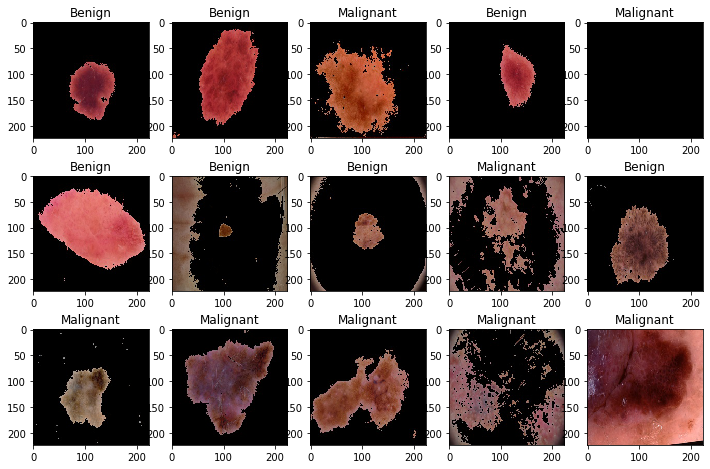

In [26]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [27]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [28]:
X_train = X_train/255.
X_test = X_test/255.

In [29]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=init))
model.add(Dense(2, activation='softmax'))


In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 200704)           

In [31]:
from tensorflow.keras.metrics import categorical_accuracy

In [32]:
 model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [33]:
model.fit(X_train, y_train, batch_size=32, epochs=10,validation_data=(X_test,y_test))
score = model.evaluate(X_test, y_test, batch_size=32)

Train on 2637 samples, validate on 660 samples
Epoch 1/10
2637/2637 [==============================] - 300s 114ms/step - loss: 0.7049 - accuracy: 0.6477 - val_loss: 0.5267 - val_accuracy: 0.7530
Epoch 2/10
2637/2637 [==============================] - 348s 132ms/step - loss: 0.4474 - accuracy: 0.7808 - val_loss: 0.4756 - val_accuracy: 0.7455
Epoch 3/10
2637/2637 [==============================] - 310s 118ms/step - loss: 0.2802 - accuracy: 0.8749 - val_loss: 0.6302 - val_accuracy: 0.7182
Epoch 4/10
2637/2637 [==============================] - 288s 109ms/step - loss: 0.1552 - accuracy: 0.9344 - val_loss: 0.7078 - val_accuracy: 0.7530
Epoch 5/10
2637/2637 [==============================] - 297s 113ms/step - loss: 0.1187 - accuracy: 0.9465 - val_loss: 0.7476 - val_accuracy: 0.7561
Epoch 6/10
2637/2637 [==============================] - 289s 110ms/step - loss: 0.0955 - accuracy: 0.9515 - val_loss: 0.8125 - val_accuracy: 0.7576
Epoch 7/10
2637/2637 [==============================] - 284s 108m

In [36]:
score

[1.0291394799044637, 0.7621212005615234]

In [44]:
y_pred = model.predict_classes(X_test)


In [45]:
print(accuracy_score(np.argmax(y_test, axis=1),y_pred))


0.7621212121212121


In [17]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 1
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

In [20]:
 model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [21]:
model.fit(X_train, y_train, batch_size=32, epochs=1,validation_data=(X_test,y_test))
score = model.evaluate(X_test, y_test, batch_size=32)

Train on 2637 samples, validate on 660 samples
Epoch 1/1
660/660 [==============================] - 147s 223ms/step


In [22]:
score

[6.322282993432247, 0.5424242615699768]